## PSO compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController
from utils.plot import *

Setting some global parameters

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_ITERATIONS = 20
NUM_PARTICLES = 20

SAVE_PSO_FILE = './results/test_PSO_save.csv'
SAVE_EVERY = 1

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


REDO

In [5]:
particle_ranges = [range(1, 21) for _ in range(5)]
particle_max_velocity = [2.5 for _ in range(5)]

share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]

def fitness_fc(particle):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    for layer in ws_controller.model_layers:
        layer.weight.requires_grad = True
    
    # share weigts by particle

    particle.data = ws_controller.share(particle.representation, share_order, retrain_amount)

    if particle.data['accuracy'] <= 0.95:
        return ACC_MULTIPLIER * particle.data['accuracy']

    return ACC_MULTIPLIER * particle.data['accuracy'] + CR_MULTIPLIER * math.log(particle.data['compression'])
    
lam_fit = lambda indiv : fitness_fc(indiv) 

In [6]:
data = {
    'time': [],
    'fitness': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['fitness'].append(particle.current_fit)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

In [7]:
pso = PSOController(NUM_PARTICLES, particle_ranges, particle_max_velocity, fitness_fc, 0.6)

if pso_data.size != 0:
    pso.load_from_pd(pso_data)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 0/20 (0) best fitness 6.151206437238436
Time 1/20 (1) best fitness 6.449044290072626
Time 2/20 (2) best fitness 6.449044290072626
Time 3/20 (3) best fitness 6.449044290072626
Time 4/20 (4) best fitness 6.449044290072626
Time 5/20 (5) best fitness 6.450356782579654
Time 6/20 (6) best fitness 6.538068571840139
Time 7/20 (7) best fitness 6.538068571840139
Time 8/20 (8) best fitness 6.538068571840139
Time 9/20 (9) best fitness 6.538068571840139
Time 10/20 (10) best fitness 6.550236408086359
Time 11/20 (11) best fitness 6.550236408086359
Time 12/20 (12) best fitness 6.550236408086359
Time 13/20 (13) best fitness 6.550236408086359
Time 14/20 (14) best fitness 6.550236408086359
Time 15/20 (15) best fitness 6.55111734134838
Time 16/20 (16) best fitness 6.55111734134838
Time 17/20 (17) best fitness 6.55111734134838
Time 18/20 (18) best fitness 6.55111734134838
Time 19/20 (19) best fitness 6.5571614734922505
Time 20/20 (20) best fitness 6.5571614734922505


[3, 13, 2, 7, 4]

In [8]:
pso_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,5.931525,"[1.6972038763263644, 12.479351787875995, 1.974...","[10, 16, 5, 9, 13]","[-0.5869564082752392, 1.2326130174201104, -0.0...",0.9748,0.0098,7.631812,0.508472,0.0,3.718971
1,0,5.897877,"[9.516668608477662, 13.419228010844986, 1.8043...","[14, 18, 20, 19, 3]","[2.5, 1.2077856517504133, -0.10640771384160884...",0.9662,0.0184,7.637553,1.053129,0.0,4.648688
2,0,5.945900,"[6.222719749044012, 11.872867947163854, 2.0269...","[15, 20, 5, 7, 13]","[-2.5, 0.8513489543243189, -0.0861758736812119...",0.9762,0.0084,7.699078,0.504366,0.0,3.948078
3,0,6.112891,"[0.9918503252443349, 14.177431079955705, 2.034...","[7, 16, 3, 12, 7]","[-1.5, 1.5, 0.04773074080922272, 0.03305681733...",0.9624,0.0222,9.614676,0.373319,0.0,3.289919
4,0,3.680800,"[14.570888037989162, 12.9038271558442, 0.91970...","[11, 16, 2, 11, 2]","[2.0888269743899737, 0.11168926843011492, 0.13...",0.9202,0.0644,16.382715,0.342190,0.0,3.956815
...,...,...,...,...,...,...,...,...,...,...,...
415,20,3.783200,"[2.9183304686637217, 12.505606331123841, 2.115...","[3, 13, 3, 6, 4]","[0.8857316452560026, -1.8256693553449943, 0.35...",0.9458,0.0388,12.189262,0.372983,0.0,3.609606
416,20,6.515402,"[2.3162337531109127, 13.304386267701203, 1.893...","[3, 14, 2, 9, 4]","[-0.3119873926096512, 0.5151029322854355, -0.6...",0.9544,0.0302,14.847059,0.324659,0.0,3.721350
417,20,3.664800,"[6.494134061817953, 13.32593081259523, 1.98541...","[7, 14, 2, 6, 3]","[1.6682600445867983, 0.1759325595187688, 0.145...",0.9162,0.0684,14.428153,0.273826,0.0,3.546164
418,20,0.420800,"[4.9882200984893785, 14.64060880352483, 0.4501...","[5, 15, 1, 6, 4]","[0.46248633257073646, 0.5517806319027331, -1.7...",0.1052,0.8794,14.525369,0.241646,0.0,3.736186


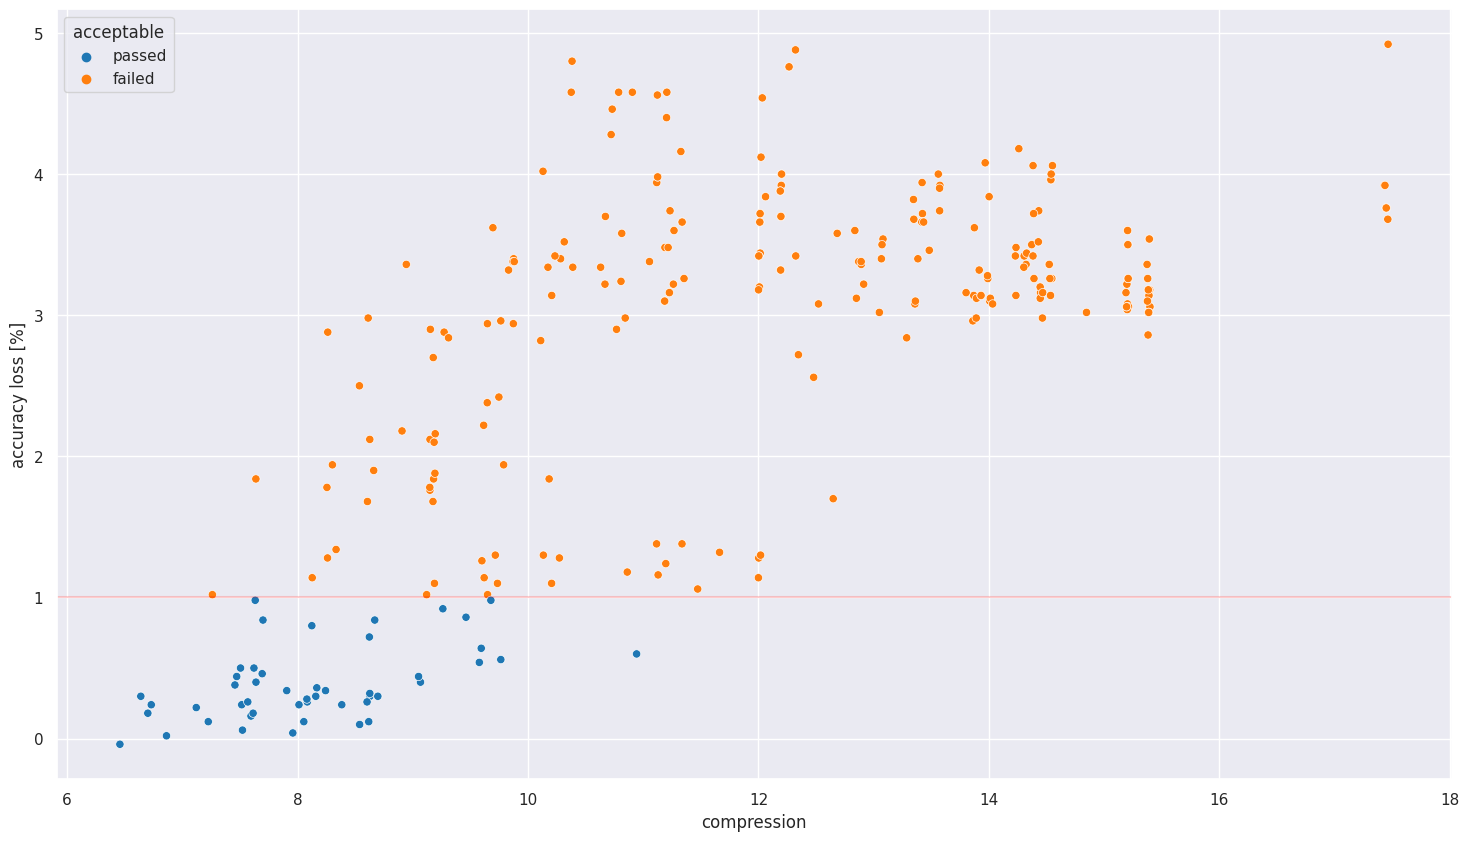

In [9]:
plot_alcr(pso_data)